In [ ]:
# ============================================================================
# INTRUSION DETECTION ML PIPELINE - JUPYTER NOTEBOOK VERSION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
from joblib import dump
import os

import warnings
warnings.filterwarnings('ignore')

# Set up beautiful plotting styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Intrusion Detection ML Pipeline - Jupyter Version")
print("=" * 60)

🚀 Intrusion Detection ML Pipeline - Jupyter Version


In [18]:
def load_dataset(split="train", data_dir="data"):
    """
    Load the NSL-KDD dataset from local files.

    Parameters:
    - split (str): Either 'train' or 'test' to select the dataset split.
    - data_dir (str): Directory where the dataset files are located.

    Returns:
    - pd.DataFrame: Loaded dataset.
    """
    if split not in ("train", "test"):
        raise ValueError("split must be either 'train' or 'test'")

    file_path = os.path.join(data_dir, f"{split}.csv")

    if not os.path.exists(file_path):
        raise FileNotFoundError(
            f"{file_path} not found. Please ensure the dataset is in the '{data_dir}' directory."
        )

    return pd.read_csv(file_path)

In [ ]:
def preprocess_network_traffic_data(
    network_traffic_dataframe: pd.DataFrame, 
    fitted_scaler=None, 
    fitted_categorical_encoders=None, 
    is_training_phase=True
):
    """
    Preprocess network traffic data with enhanced visualization.
    """
    processed_dataframe = network_traffic_dataframe.copy()
    
    # Convert to binary classification
    processed_dataframe['class'] = processed_dataframe['class'].apply(
        lambda traffic_class: 'normal' if traffic_class == 'normal' else 'attack'
    )
    
    # Data quality visualization
    if is_training_phase:
         # Class distribution
        class_counts = processed_dataframe['class'].value_counts()
        
        # Create beautiful class distribution plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Pie chart
        colors = ['#FF6B6B', '#4ECDC4']
        ax1.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
                colors=colors, startangle=90, explode=(0.05, 0))
        ax1.set_title('Traffic Classification Distribution', fontsize=14, fontweight='bold')
        
        # Bar chart
        bars = ax2.bar(class_counts.index, class_counts.values, color=colors, alpha=0.8)
        ax2.set_title('Traffic Counts by Class', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Number of Connections')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Missing values heatmap
        if processed_dataframe.isnull().sum().sum() > 0:
            plt.figure(figsize=(12, 8))
            sns.heatmap(processed_dataframe.isnull(), cbar=True, yticklabels=False,
                       cmap='viridis', alpha=0.8)
            plt.title('Missing Values Heatmap', fontsize=16, fontweight='bold')
            plt.show()
        else:
            print("No missing values found!")
    
    # Remove missing values
    processed_dataframe.dropna(inplace=True)
    
    # Separate features and labels
    network_features = processed_dataframe.drop('class', axis=1)
    intrusion_labels = processed_dataframe['class']
    
    if is_training_phase:
        # Encode categorical features
        categorical_feature_encoders = {}
        categorical_columns = network_features.select_dtypes(include='object').columns
        
        for categorical_column in categorical_columns:
            label_encoder = LabelEncoder()
            network_features[categorical_column] = label_encoder.fit_transform(
                network_features[categorical_column]
            )
            categorical_feature_encoders[categorical_column] = label_encoder
        
        # Scale features
        numerical_feature_scaler = StandardScaler()
        scaled_network_features = numerical_feature_scaler.fit_transform(network_features)
        
        return (scaled_network_features, intrusion_labels, 
                numerical_feature_scaler, categorical_feature_encoders)
    else:
        # Apply fitted encoders and scaler
        for column_name, fitted_encoder in fitted_categorical_encoders.items():
            if column_name in network_features.columns:
                try:
                    network_features[column_name] = fitted_encoder.transform(
                        network_features[column_name]
                    )
                except ValueError:
                    known_classes = fitted_encoder.classes_
                    network_features[column_name] = network_features[column_name].apply(
                        lambda x: x if x in known_classes else known_classes[0]
                    )
                    network_features[column_name] = fitted_encoder.transform(
                        network_features[column_name]
                    )
        
        scaled_network_features = fitted_scaler.transform(network_features)
        return (scaled_network_features, intrusion_labels, fitted_scaler, fitted_categorical_encoders)


In [ ]:
def train_intrusion_detection_model_with_visuals(
    training_feature_matrix, testing_feature_matrix,
    training_intrusion_labels, testing_intrusion_labels
):
    """
    Train Random Forest with beautiful visualizations instead of text logs.
    """
    print("TRAINING INTRUSION DETECTION MODEL")
    print("=" * 50)

    # Train the model
    intrusion_detection_classifier = RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1
    )

    intrusion_detection_classifier.fit(
        training_feature_matrix, training_intrusion_labels)
    predicted_intrusion_labels = intrusion_detection_classifier.predict(
        testing_feature_matrix)
    prediction_probabilities = intrusion_detection_classifier.predict_proba(
        testing_feature_matrix)

    # Calculate metrics
    model_accuracy = accuracy_score(
        testing_intrusion_labels, predicted_intrusion_labels)
    model_precision = precision_score(
        testing_intrusion_labels, predicted_intrusion_labels, pos_label='attack')
    model_recall = recall_score(
        testing_intrusion_labels, predicted_intrusion_labels, pos_label='attack')
    model_f1_score = f1_score(testing_intrusion_labels,
                              predicted_intrusion_labels, pos_label='attack')

    # VISUALIZATION 1: Performance Metrics Dashboard
    fig = go.Figure()

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [model_accuracy, model_precision, model_recall, model_f1_score]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    fig.add_trace(go.Bar(
        x=metrics,
        y=values,
        marker_color=colors,
        text=[f'{v:.3f}' for v in values],
        textposition='auto',
        name='Performance Metrics'
    ))

    fig.update_layout(
        title='Model Performance Dashboard',
        title_font_size=20,
        xaxis_title='Metrics',
        yaxis_title='Score',
        yaxis=dict(range=[0, 1]),
        height=500,
        showlegend=False,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)'
    )
    fig.show()

    # VISUALIZATION 2: Confusion Matrix Heatmap
    cm = confusion_matrix(testing_intrusion_labels, predicted_intrusion_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Attack', 'Normal'],
                yticklabels=['Attack', 'Normal'],
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)

    # Add performance annotations
    tn, fp, fn, tp = cm.ravel()
    plt.text(1.5, -0.1, f'True Positives: {tp:,}', transform=plt.gca().transAxes,
             fontsize=12, color='green', fontweight='bold')
    plt.text(1.5, -0.15, f'False Positives: {fp:,}', transform=plt.gca().transAxes,
             fontsize=12, color='red', fontweight='bold')
    plt.text(1.5, -0.2, f'False Negatives: {fn:,}', transform=plt.gca().transAxes,
             fontsize=12, color='orange', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # VISUALIZATION 3: ROC Curve
    fpr, tpr, _ = roc_curve(
        testing_intrusion_labels.map({'attack': 1, 'normal': 0}),
        prediction_probabilities[:, 1]
    )
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=3,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Intrusion Detection Performance',
              fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # VISUALIZATION 4: Feature Importance
    feature_importance_scores = intrusion_detection_classifier.feature_importances_
    feature_indices = np.argsort(feature_importance_scores)[
        ::-1][:20]  # Top 20

    plt.figure(figsize=(12, 10))
    top_scores = feature_importance_scores[feature_indices]

    bars = plt.barh(range(len(top_scores)), top_scores[::-1],
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_scores))))

    plt.yticks(range(len(top_scores)),
               [f'Feature_{idx}' for idx in feature_indices[::-1]])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 20 Most Important Features',
              fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # SUMMARY REPORT
    print("MODEL TRAINING SUMMARY")
    print("=" * 40)
    print(f"Accuracy:  {model_accuracy:.3f}")
    print(f" Precision: {model_precision:.3f}")
    print(f"Recall:    {model_recall:.3f}")
    print(f"F1-Score:  {model_f1_score:.3f}")
    print(f"AUC-ROC:   {roc_auc:.3f}")
    print(f"Model saved to: models/intrusion_detection_model.pkl")

    # Save model
    os.makedirs("models", exist_ok=True)
    dump(intrusion_detection_classifier, "models/intrusion_detection_model.pkl")

    return intrusion_detection_classifier

In [ ]:
def predict_network_anomaly_with_visuals(network_connection_sample, trained_classifier):
    """
    Make prediction with confidence visualization.
    """
    connection_dataframe = pd.DataFrame([network_connection_sample])
    
    # Handle categorical features
    categorical_columns = connection_dataframe.select_dtypes(include='object').columns
    for categorical_column in categorical_columns:
        connection_dataframe[categorical_column] = (
            connection_dataframe[categorical_column].astype("category").cat.codes
        )
    
    connection_dataframe = connection_dataframe.fillna(0)
    
    # Make prediction
    predicted_class = trained_classifier.predict(connection_dataframe)[0]
    prediction_probabilities = trained_classifier.predict_proba(connection_dataframe)[0]
    
    # Visualize prediction confidence
    classes = trained_classifier.classes_
    
    fig = go.Figure(data=[
        go.Bar(x=classes, y=prediction_probabilities, 
               marker_color=['red' if c == 'attack' else 'green' for c in classes])
    ])
    
    fig.update_layout(
        title=f'Prediction: {predicted_class.upper()} (Confidence: {max(prediction_probabilities):.1%})',
        title_font_size=16,
        xaxis_title='Classification',
        yaxis_title='Probability',
        height=400
    )
    fig.show()
    
    return predicted_class

In [ ]:
def main_intrusion_detection_pipeline():
    # Load network traffic datasets
    print("Loading network traffic datasets...")
    training_network_data = load_dataset(split="train")
    testing_network_data = load_dataset("test")

    print(f"Training dataset dimensions: {training_network_data.shape}")
    print(f"Testing dataset dimensions: {testing_network_data.shape}")


    # Preprocess network traffic features
    print("\nPreprocessing network traffic features...")
    (processed_training_features,
     training_labels,
     feature_scaler,
     categorical_encoders) = preprocess_network_traffic_data(
        training_network_data,
        is_training_phase=True
    )

    (processed_testing_features,
     testing_labels,
     _, _) = preprocess_network_traffic_data(
        testing_network_data,
        feature_scaler,
        categorical_encoders,
        is_training_phase=False
    )

    # Train intrusion detection model
    print("\nTraining intrusion detection model...")
    trained_classifier = train_intrusion_detection_model_with_visuals(
        processed_training_features,
        processed_testing_features,
        training_labels,
        testing_labels
    )

    # Test single prediction
    print("\nTesting single network connection prediction...")
    test_network_sample = testing_network_data.drop(
        columns=["class"]).iloc[0].to_dict()

    anomaly_prediction_result = predict_network_anomaly_with_visuals(
        test_network_sample, trained_classifier)
    print(f"Network anomaly prediction: {anomaly_prediction_result}")

    # Display model performance summary
    print("\nModel training and evaluation completed!")
    print(" Check the 'models/' directory for visualization plots:")
    print("  - confusion_matrix.png")
    print("  - roc_curve.png")
    print("  - feature_importance.png")

Loading network traffic datasets...
Training dataset dimensions: (151165, 42)
Testing dataset dimensions: (34394, 42)

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151165 entries, 0 to 151164
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     151165 non-null  int64  
 1   protocol_type                151165 non-null  object 
 2   service                      151165 non-null  object 
 3   flag                         151165 non-null  object 
 4   src_bytes                    151165 non-null  int64  
 5   dst_bytes                    151165 non-null  int64  
 6   land                         151165 non-null  int64  
 7   wrong_fragment               151165 non-null  int64  
 8   urgent                       151165 non-null  int64  
 9   hot                          151165 non-null  int64  
 10  num_failed_logins            15116

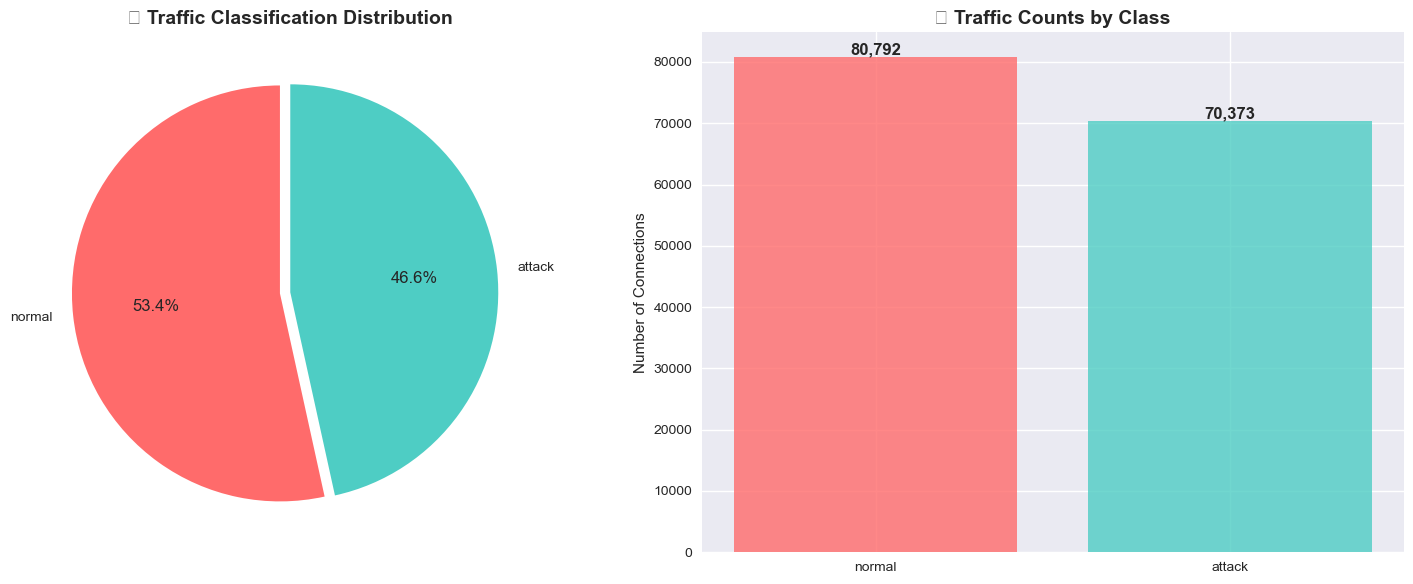

✅ No missing values found!

Training intrusion detection model...
🤖 TRAINING INTRUSION DETECTION MODEL


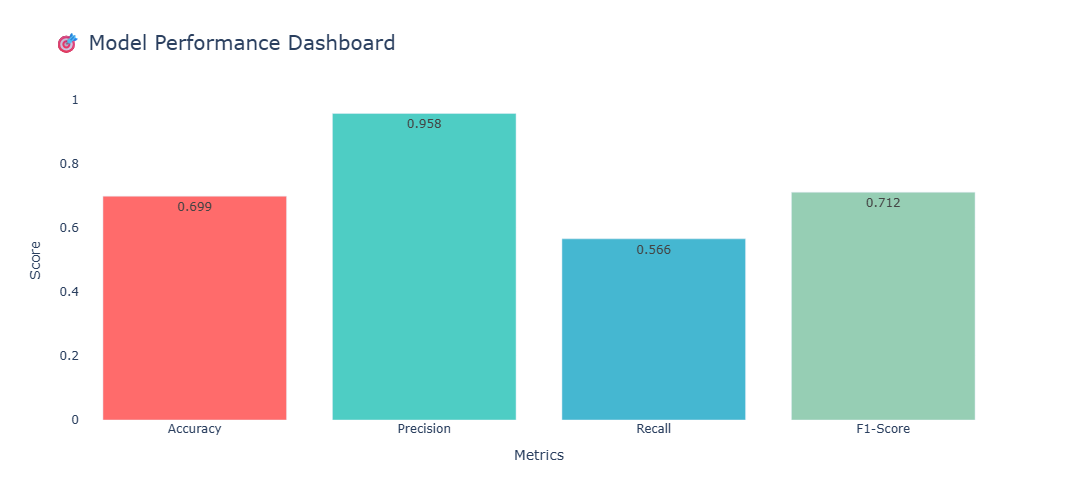

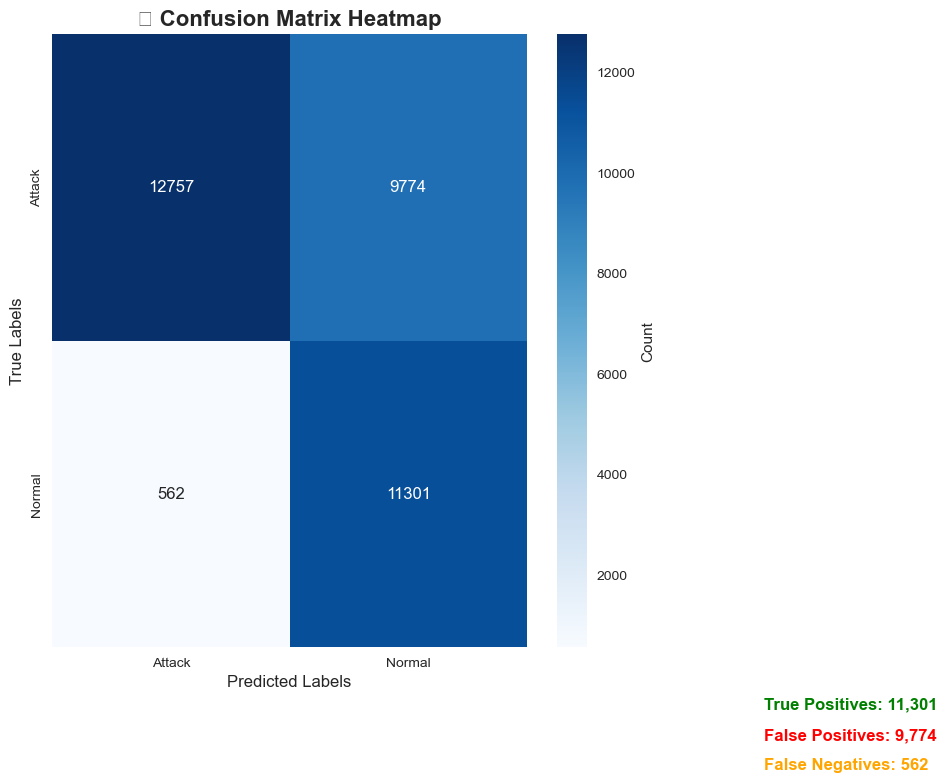

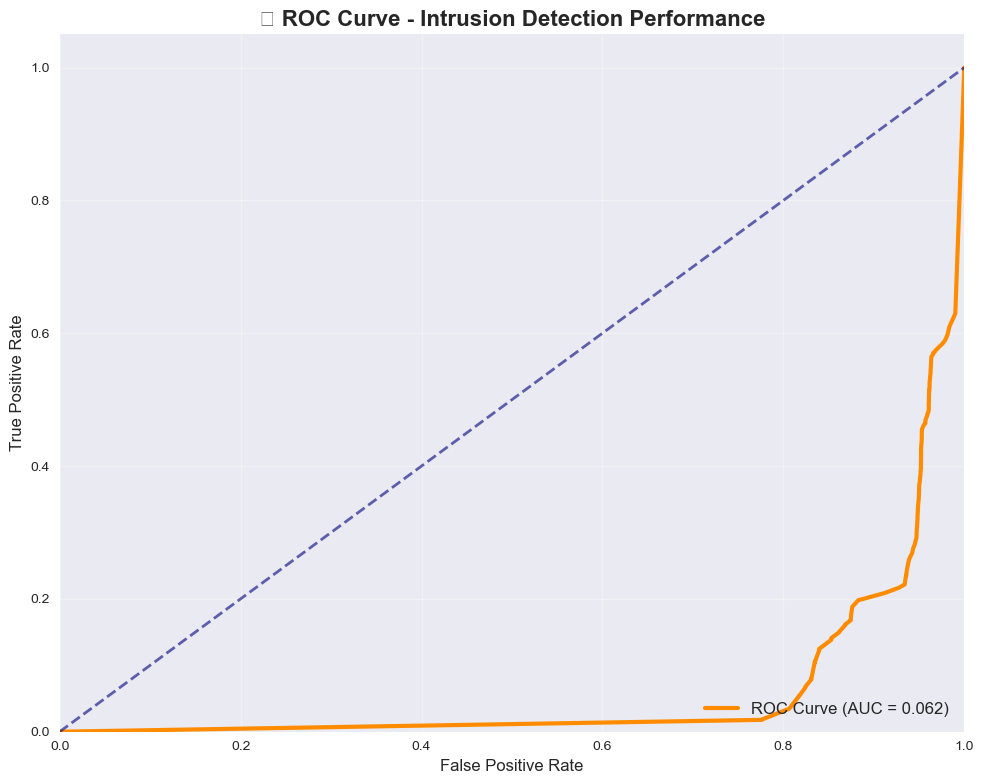

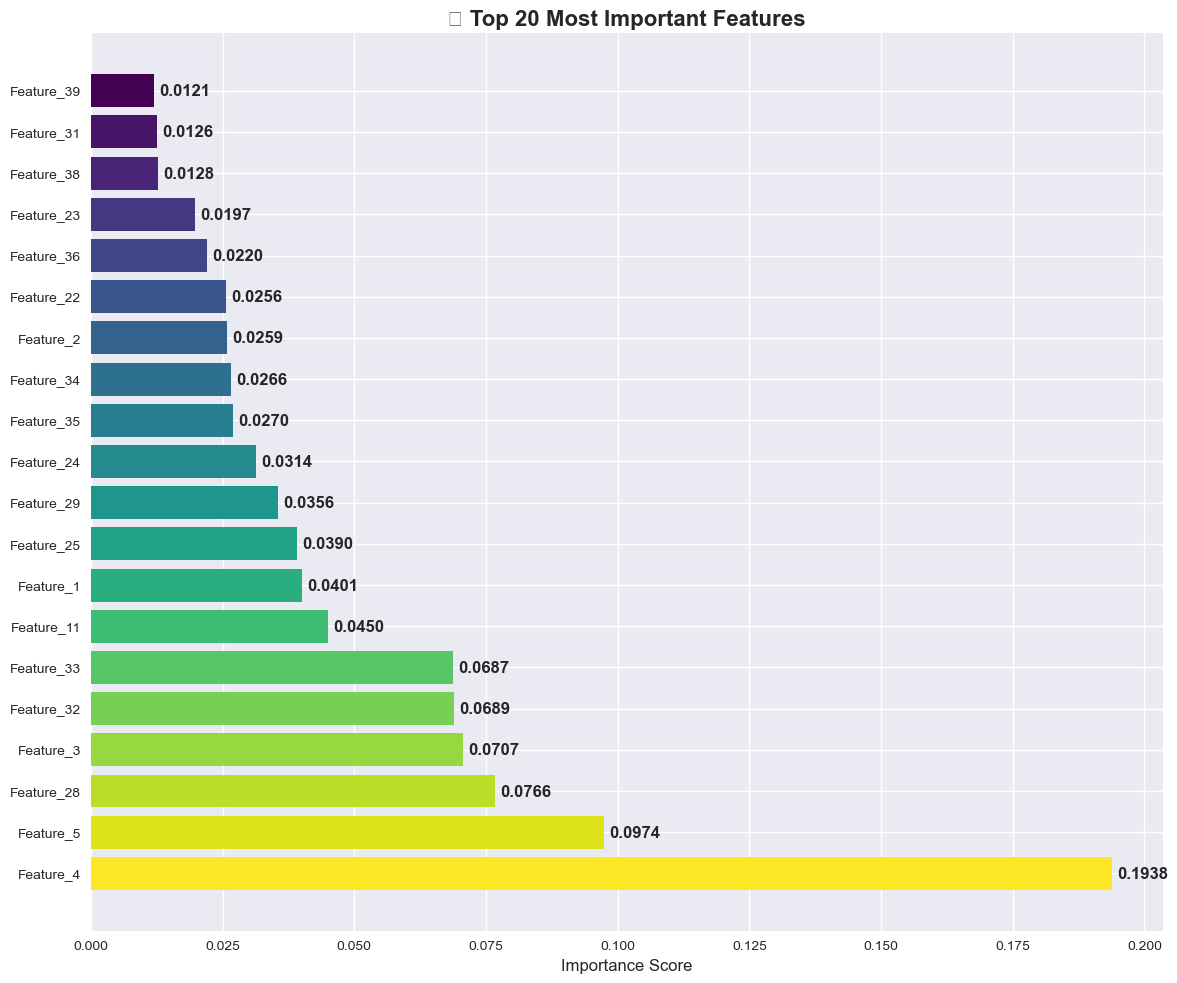

📊 MODEL TRAINING SUMMARY
✅ Accuracy:  0.699
🎯 Precision: 0.958
🔍 Recall:    0.566
⚖️  F1-Score:  0.712
📈 AUC-ROC:   0.062
💾 Model saved to: models/intrusion_detection_model.pkl

Testing single network connection prediction...


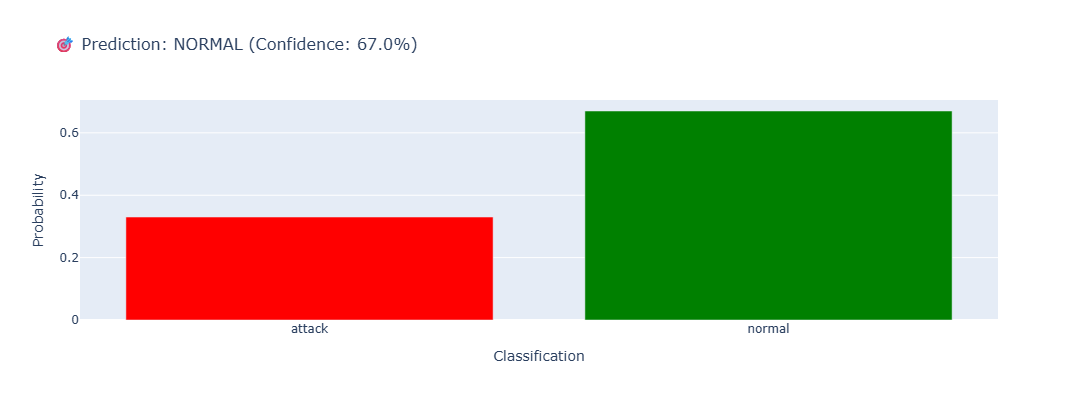

Network anomaly prediction: normal

Model training and evaluation completed!
 Check the 'models/' directory for visualization plots:
  - confusion_matrix.png
  - roc_curve.png
  - feature_importance.png


In [25]:
main_intrusion_detection_pipeline()